In [2]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPool2D,concatenate, add
from keras import applications
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.layers import GlobalAveragePooling2D,Dense
from keras.models import Model, load_model
from keras import optimizers
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, CSVLogger,ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,roc_curve,confusion_matrix,accuracy_score,log_loss
from pprint import pprint
from keras import backend as K
from keras.preprocessing import image

In [2]:
img_width = 224                                                                      #parameter：the width of image        
img_height = 224                                                                      #parameter：the height of image
batch_size = 32                                                                      #parameter：the number of image in one batch

model_dir = '....../VGG16.h5'    #parameter: the path of saving model after training
check_point_model_dir = '....../check_point_VGG16.h5'  #parameter: the path of saving check poing model. Don't care it if you don't use the callback of ModelCheckpoint.

train_data_dir = '....../datasets/train'                         #parameter: the path of training dataset
validation_data_dir = '....../datasets/validate'                   #parameter: the path of validate dataset
benign_dir = '....../datasets/validate/negative/'                   #parameter: the path of negative category in validate dateset
malignant_dir = '....../datasets/validate/positive/'             #parameter: the path of positive category in validate dateset
train_benign_dir = '....../datasets/train/negative/'                #parameter: the path of negative category in training dateset
train_malignant_dir = '....../datasets/train/negative/'             #parameter: the path of positive category in training dateset

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')
val_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

Found 4018 images belonging to 2 classes.
Found 445 images belonging to 2 classes.


In [ ]:
#the process of design a deep learning model. You can load a model througn "load_model", too.
base_model = VGG16(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)
VGG16_model = Model(inputs=base_model.input, outputs=prediction)

for base_layer in base_model.layers:
    base_layer.trainable = False

VGG16_model.summary()

sgd = optimizers.SGD(lr=0.001)
VGG16_model.compile(optimizer=sgd,loss='binary_crossentropy') 

In [6]:
#generate the label of validate dataset.
num_benign = len(os.listdir(benign_dir))
benign_label = np.zeros(num_benign, dtype=np.int8)
print('benign_label: ', benign_label)
num_malignant = len(os.listdir(malignant_dir))
malignant_label = np.ones(num_malignant, dtype=np.int8)
print('malignant_label: ', malignant_label)
label = np.hstack((benign_label, malignant_label))
print('label: ', label)

##generate the label of training dataset.
train_num_benign = len(os.listdir(train_benign_dir))
train_benign_label = np.zeros(train_num_benign, dtype=np.int8)
print('train_benign_label:', train_benign_label, 'number of train_benign_label:', len(train_benign_label))
train_num_malignant = len(os.listdir(train_malignant_dir))
train_malignant_label = np.ones(train_num_malignant, dtype=np.int8)
print('train_malignant_label:', train_malignant_label,  'number of train_malignant_label:', len(train_malignant_label))
train_label = np.hstack((train_benign_label, train_malignant_label))
print('train_label:', train_label,  'number of train_label:', len(train_label))

benign_predict = []
malignant_predict = []
train_benign_predict = []
train_malignant_predict = []

train_loss_score = []
train_f1_score = []
train_recall_score = []
train_precision_score = []
train_acc = []
train_auc_score = []
val_loss = []
val_acc = []
val_f1_score = []
val_recall_score = []
val_precision_score = []
val_auc_score = []

benign_label [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
malignant_label [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
label [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [20]:
class Evaluate(Callback):
    def __init__(self):
        super().__init__()
        
    def on_epoch_end(self, logs={}):
        benign_predict = []
        malignant_predict = []
        train_benign_predict = []
        train_malignant_predict = []
        
        #calculate the evaluation criteria of validate dateset
        for img_name in os.listdir(benign_dir):
            img_path = os.path.join(benign_dir, img_name)
            img = image.load_img(img_path, target_size=(img_width, img_height))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            benign_result = self.model.predict(x)
            benign_result = eval(str(benign_result).strip('[]'))
            benign_predict.append(benign_result)
        benign_predict_score = np.asanyarray(benign_predict, dtype=float)
        benign_predict1 = np.asanyarray(np.asarray(benign_predict, dtype=float).round(),dtype=np.int8)     
        for img_name in os.listdir(malignant_dir):
            img_path = os.path.join(malignant_dir, img_name)
            img = image.load_img(img_path, target_size=(img_width, img_height))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            malignant_result = self.model.predict(x)
            malignant_result = eval(str(malignant_result).strip('[]'))
            malignant_predict.append(malignant_result)
        malignant_predict_score = np.asanyarray(malignant_predict, dtype=float)
        malignant_predict1 = np.asarray(np.asarray(malignant_predict, dtype=float).round(),dtype=np.int8)
        predict_score = np.hstack((benign_predict_score, malignant_predict_score))
        predict = np.hstack((benign_predict1, malignant_predict1))
#         print('predict_score', predict_score)
#         print('predict', predict)
        
        #calculate the evaluation criteria of training dateset
        for img_name in os.listdir(train_benign_dir):
            img_path = os.path.join(train_benign_dir, img_name)
            img = image.load_img(img_path, target_size=(img_width, img_height))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            train_benign_result = self.model.predict(x)
            train_benign_result = eval(str(train_benign_result).strip('[]'))
            train_benign_predict.append(train_benign_result)
        train_benign_predict_score = np.asanyarray(train_benign_predict, dtype=float)
        train_benign_predict1 = np.asanyarray(np.asarray(train_benign_predict, dtype=float).round(),dtype=np.int8) 
        for img_name in os.listdir(train_malignant_dir):
            img_path = os.path.join(train_malignant_dir, img_name)
            img = image.load_img(img_path, target_size=(img_width, img_height))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            train_malignant_result = self.model.predict(x)
            train_malignant_result = eval(str(train_malignant_result).strip('[]'))
            train_malignant_predict.append(train_malignant_result)
        train_malignant_predict_score = np.asanyarray(train_malignant_predict, dtype=float)
        train_malignant_predict1 = np.asarray(np.asarray(train_malignant_predict, dtype=float).round(),dtype=np.int8)
        
        train_predict_score = np.hstack((train_benign_predict_score, train_malignant_predict_score))
        train_predict = np.hstack((train_benign_predict1, train_malignant_predict1))
#         print('train_predict_score', train_predict_score)
#         print('train_predict', train_predict, len(train_predict))
        
        tn, fp, fn, tp = confusion_matrix(label, predict).ravel()
        print('tn',tn)
        print('fp',fp)
        print('fn',fn)
        print('tp',tp)
        validate_loss = log_loss(label, predict)
        print('validate_loss', validate_loss)
        accuracy = accuracy_score(label, predict)
        print('accuracy', accuracy)
        precision = precision_score(label, predict,average='binary')
        print('precision', precision)      
        recall = recall_score(label, predict,average='binary')
        print('recall', recall)        
        f1 = f1_score(label, predict,average='binary')
        print('f1', f1)
        auc = roc_auc_score(label, predict_score)
        print('auc', auc)
        fpr, tpr, thresholds = roc_curve(label, predict_score, pos_label=1)
        
        train_tn, train_fp, train_fn, train_tp = confusion_matrix(train_label, train_predict).ravel()
        print('train_tn',train_tn)
        print('train_fp',train_fp)
        print('train_fn',train_fn)
        print('train_tp',train_tp)
        train_loss = log_loss(train_label, train_predict)
        print('train_loss', train_loss)
        train_accuracy = accuracy_score(train_label, train_predict)
        print('train_accuracy', train_accuracy)
        train_precision = precision_score(train_label, train_predict,average='binary')
        print('train_precision', train_precision)      
        train_recall = recall_score(train_label, train_predict,average='binary')
        print('train_recall', train_recall)        
        train_f1 = f1_score(train_label, train_predict,average='binary')
        print('train_f1', train_f1)
        train_auc = roc_auc_score(train_label, train_predict_score)
        print('train_auc', train_auc)
        train_fpr, train_tpr, train_thresholds = roc_curve(train_label, train_predict_score, pos_label=1)
        
        plt.figure(figsize=(5,5))     
        plt.plot(train_fpr,train_tpr,color='blue',linewidth=3,label='train_AUC (area:%0.4f)'%train_auc)  
        plt.plot(fpr,tpr,color='red',linewidth=3,label='validate_AUC (area:%0.4f)'%auc)  
        plt.plot([0, 1], [0, 1], color='black',linewidth=2, linestyle='--')  
        plt.xlim([0, 1])  
        plt.ylim([0, 1])  
        plt.xlabel('False Positive Rate')  
        plt.ylabel('True Positive Rate')  
        plt.title('ROC')  
        plt.legend(loc="lower right")      
        plt.show()
        
        train_loss_score.append(train_loss)
        train_acc.append(train_accuracy)
        train_precision_score.append(train_precision)
        train_recall_score.append(train_recall)
        train_f1_score.append(train_f1)
        train_auc_score.append(train_auc)
        val_loss.append(validate_loss)
        val_acc.append(accuracy)
        val_precision_score.append(precision)
        val_recall_score.append(recall)
        val_f1_score.append(f1)
        val_auc_score.append(auc)
            
 #the optional callback
evaluate = Evaluate()
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto', restore_best_weights=True)
adjust_lr = ReduceLROnPlateau('loss', patience=3, verbose=1, factor=0.8)
check_point = ModelCheckpoint(check_point_model_dir, save_best_only=True,monitor='loss', verbose=1)

In [ ]:
#train the model.
history = VGG16_model.fit_generator(generator=train_generator,           
                    steps_per_epoch=4018 // batch_size,     #parameter: you need to change 4018 which is the total number of images in training dateset.
                    epochs=10,                              #parameter: the epochs of train model
                    validation_data=val_generator,
                    validation_steps=445 // batch_size,     #parameter: you need to change 445 which is the total number of images in validate dateset.
                    callbacks=[evaluate,adjust_lr]
                    )
VGG16_model.save(model_dir)

epoch:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

train_loss:  [0.6296235824416497, 0.5032167576167603, 0.4483967644605985, 0.41055885114010776, 0.38264483416384915, 0.36013111440790374, 0.34375777507819233, 0.32531420594761234, 0.31246305348488707, 0.29887867806610846, 0.2834244950837234, 0.27563013043860884, 0.2652065701704355, 0.25217594787605296, 0.24510523131416628, 0.23770162866123928, 0.2272412564473028, 0.22561544411231352, 0.2161232370679893, 0.20465656059887866, 0.20490065408785701, 0.19745617604995885, 0.19006152507747837, 0.18441395289938511, 0.18020018159179133, 0.1765977742227842, 0.17148690505077316, 0.16437172980370018, 0.1612

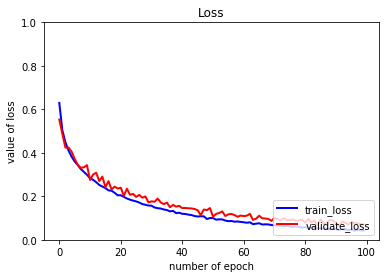

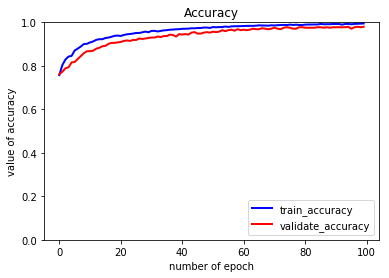

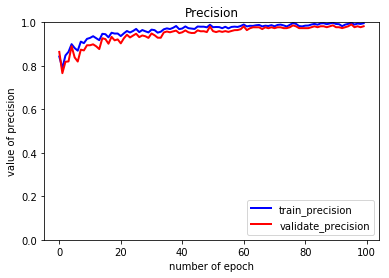

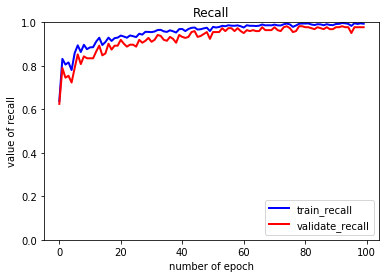

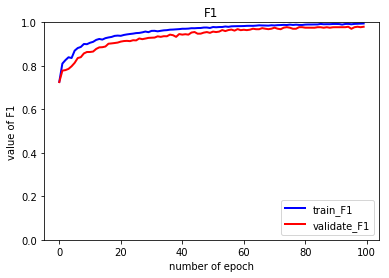

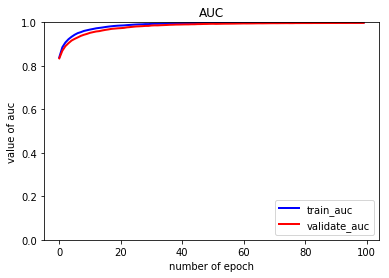

In [18]:
print("epoch: ",epoch)
print()
print("train_loss: ",train_loss)
print()
print("val_loss: ",val_loss)
print()
print("train_acc: ",train_acc)
print()
print("val_acc: ",val_acc)
print()
print("train_precision_score: ",train_precision_score)
print()
print("val_precision_score: ",val_precision_score)
print()
print("train_recall_score: ",train_recall_score)
print()
print("val_recall_score: ",val_recall_score)
print()
print("train_f1_score: ",train_f1_score)
print()
print("val_f1_score: ",val_f1_score)
print()

plt.figure(figsize=(6,4))     
plt.plot(epoch, train_loss,color='blue',linewidth=2,label='train_loss')  
plt.plot(epoch,val_loss,color='red',linewidth=2,label='validate_loss')  
# plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.xlabel('number of epoch')  
plt.ylabel('value of loss')  
plt.title('Loss')  
plt.legend(loc="lower right")      
plt.show()

plt.figure(figsize=(6,4))     
plt.plot(epoch, train_acc,color='blue',linewidth=2,label='train_accuracy')  
plt.plot(epoch,val_acc,color='red',linewidth=2,label='validate_accuracy')  
# plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.xlabel('number of epoch')  
plt.ylabel('value of accuracy')  
plt.title('Accuracy')  
plt.legend(loc="lower right")      
plt.show()
          
plt.figure(figsize=(6,4))     
plt.plot(epoch, train_precision_score,color='blue',linewidth=2,label='train_precision')  
plt.plot(epoch,val_precision_score,color='red',linewidth=2,label='validate_precision')  
# plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.xlabel('number of epoch')  
plt.ylabel('value of precision')  
plt.title('Precision')  
plt.legend(loc="lower right")      
plt.show()
          
plt.figure(figsize=(6,4))     
plt.plot(epoch, train_recall_score,color='blue',linewidth=2,label='train_recall')  
plt.plot(epoch,val_recall_score,color='red',linewidth=2,label='validate_recall')  
# plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.xlabel('number of epoch')  
plt.ylabel('value of recall')  
plt.title('Recall')  
plt.legend(loc="lower right")      
plt.show()
          
plt.figure(figsize=(6,4))     
plt.plot(epoch, train_f1_score,color='blue',linewidth=2,label='train_F1')  
plt.plot(epoch,val_f1_score,color='red',linewidth=2,label='validate_F1')  
# plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.xlabel('number of epoch')  
plt.ylabel('value of F1')  
plt.title('F1')  
plt.legend(loc="lower right")      
plt.show()

plt.figure(figsize=(6,4))     
plt.plot(epoch, train_auc_score,color='blue',linewidth=2,label='train_auc')  
plt.plot(epoch,val_auc_score,color='red',linewidth=2,label='validate_auc')  
# plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.xlabel('number of epoch')  
plt.ylabel('value of auc')  
plt.title('AUC')  
plt.legend(loc="lower right")      
plt.show()